
<h1><center>Weather or Not, There is Crime</center></h1>
<center>
*Jason Stock, Tom Cavey, Amber Lee*  
*Relationships between crime and weather patterns in Chicago*
</center>

In [192]:
import neuralnetworks as nn
import mlutils as ml
import pandas as pd
import numpy as np 
import random
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import dill

class Models:
    
    def __init__(self, num_districts, networks):
        """Initialize number of districts and repsective networks"""
        self.num_districts = num_districts
        self.networks = networks
        self.trained_nn = []
        
    def sampler(self, data, features, targets):
        """Sample the data to set features, X, and targets, T."""
        X = data.iloc[:, np.r_[features]]
        T = data.iloc[:, np.r_[targets]]
        return np.array(X), np.array(T)

    def train(self, iterations=1000, normalize=True, partition=False):
        """Train each network and save the trained nnet object to trained_nn,
        Use all the values for training, i.e., partition=False"""
        for d in range(self.num_districts):
            data = pd.read_csv('../output/WeeklyOutput/wc'+str(d + 1)+'.csv', sep=',', low_memory=False, 
            names = ['date', 'dry', 'wet', 'wind', 'humidity', 'district', 'homicide', 'robbery',
                     'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']).iloc[70:]
            if normalize:
                cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
                data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

            X, T = sampler(data, range(1,5), range(6,14))
        
            if partition: 
                train_f = 0.80
                Xtrain, Ttrain, _, _ = ml.partition(X, T, (train_f, 1 - train_f))

                nnet = nn.NeuralNetwork(Xtrain.shape[1], self.networks[d], Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, iterations)
            else:  
                nnet = nn.NeuralNetwork(X.shape[1], self.networks[d], T.shape[1]) 
                nnet.train(X, T, iterations)
            
            self.trained_nn.append(nnet)
    
    def use(self, data, return_all=True, district=None):
        """Prints a table of all or specific district results based off provided data.
        The data shall be the weather for the day in the form:
        [dry-bulb-temp, wet-bulb-temp, wind-speed, relative-humidity]"""
        results = []
        _index = range(1, 10)
        
        if return_all:
            for i, network in enumerate(self.trained_nn):
                Y = np.round(network.use(data)[0])
                results.append(np.absolute(Y))
        elif district is not None:
            Y = np.round(self.trained_nn[district - 1].use(data)[0])
            results.append(np.absolute(Y))
            _index = district
        else:
            print('ERROR, return_all = True, or set to false and specify district number.')
        df = pd.DataFrame(results, columns=['Homicide', 'Robbery', 'Battery', 'Assault',
                                            'Burglary', 'Theft', 'Motor Theft', 'Weapons Assault'],
                          index=_index).astype(int)
        
        district_names = ['Far North Side', 'North Side', 'N-W Side', 'Central', 'West Side',
                          'S-W Side', 'South Side', 'Far S-W Side', 'Far West Side']
        for i in _index:
            print('| {0}:{1:>15} '.format(i, district_names[i-1]), end='')
            if i == 5:
                print()  
        print('|')
        
        return df.head(10)

    
def save_dill(iterations=1000, normalize=True, partition=False):
    """Train Models class with defined networks.
    Then save class to a .pickle file"""
    networks = [
                [5], # district 1
                [5], # district 2
                [5], # district 3
                [5], # district 4
                [5], # district 5
                [5], # district 6
                [5], # district 7
                [5], # district 8
                [5], # district 9
               ]

    M = Models(len(networks), networks)
    M.train(iterations, normalize, partition)

    outfile = open('trained_models.pickle', 'wb')
    dill.dump(M, outfile)
    outfile.close()
    
def sampler(data, a, b):
    """Sample the data to set features, X, and targets, T."""
    X = data.iloc[:, np.r_[a]]
    T = data.iloc[:, np.r_[b]]
        
    return np.array(X), np.array(T)

def get_values(X, T, network, train_f, itr, partition = False):
    """Get test results and error trace"""
    if partition: 
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

def network_test(district='4'):
    """Display a run with 20 networks - graphing the error output"""
    data = read_data(district).iloc[70:]
    
    cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
    data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    X, T = sampler(data, range(1, 5), range(6,14))

    sns.set_style("whitegrid")

    numberItr = 1200
    train_f = 0.8
    er = []
    networks = []
    for i in range(20):
        a = random.sample(range(1, 100), np.random.randint(1, 6))
        Y, _T, error = get_values(X, T, a, train_f, numberItr)
        er.append(error)
        networks.append(a)
        numberItr = int(1.05 * numberItr)

    color=iter(cm.rainbow(np.linspace(0,1,20)))
    plt.figure(figsize=(18,8))
    for i, pl in enumerate(er):
        plt.plot(pl, c=next(color), label = 'Network '+str(networks[i]))

    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    plt.show()
    
def bar_test(year=5, district='4'):
    """Display the crime data for a given year and district"""
    def bar_crime(data, year):
        col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
        plt.figure(figsize=(18,25))

        for i in range(len(col)):
            plt.subplot(4,2,i+1)  
            y = data[col[i]][52*(year - 1):52*year]
            x = np.arange(len(y))
            z = np.polyfit(x, y, 3)

            p = np.poly1d(z)
            p30 = np.poly1d(np.polyfit(x, y, 15))
            xp = np.linspace(0, len(y) - 1, 50)

            plt.bar(x, y, color='tan')
            _ = plt.plot(xp, p(xp), 'k--', xp, p30(xp), 'b-', lw=2.5)
            plt.title(col[i])
            plt.xlabel('days (samples)'), plt.ylabel('num crimes') 

        plt.show() 

    data = read_data(district).iloc[70:]
    bar_crime(data, year)

    
def read_data(district='5'):
    return pd.read_csv('../output/WeeklyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
                names = ['date', 'dry', 'wet', 'wind', 'humidity', 'district', 'homicide', 'robbery',
                         'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons'])
def data_tail():
    return read_data().tail()

def crime_head():
    return pd.read_csv('../archive/sample/crime_records.csv', sep=',').head(4)
                
def weather_head():
    return pd.read_csv('../archive/sample/weather.csv', sep=',').iloc[:, : 19].head()

In [193]:
# IMPORT ABOVE FILE

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Problem

## - BLAH
## - BLAH
## - BLAH

# Data

## - BLAH
## - BLAH
## - BLAH

## Original Weather Data

In [3]:
weather_head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPF,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPF,HOURLYWETBULBTEMPC,HOURLYDewPointTempF,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection
0,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 00:52,FM-15,CLR:00,10.0,NaN,25,-3.9,23,-5.3,17,-8.3,72,5,270
1,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 01:52,FM-15,CLR:00,10.0,NaN,23,-5.0,21,-6.2,16,-8.9,74,5,280
2,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 02:52,FM-15,CLR:00,10.0,NaN,21,-6.1,19,-7.1,15,-9.4,78,0,0
3,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 03:52,FM-15,CLR:00,10.0,NaN,19,-7.2,17,-8.1,13,-10.6,77,0,0
4,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 04:52,FM-15,CLR:00,10.0,NaN,17,-8.3,16,-9.1,12,-11.1,80,0,0


## Original Crime Data

In [4]:
crime_head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28,25,04B,1144606,1903566,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,...,15,67,26,1166468,1860715,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,4,39,08B,1185075,1875622,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,3,40,08B,1178033,1870804,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"


## Aggregated Data

In [187]:
data_tail()

,date,dry,wet,wind,humidity,district,homicide,robbery,battery,assault,burglary,theft,motor,weapons
926,2018037,69.212739,59.030585,4.519358,72.286077,5,4,61,248,99,48,254,44,34
927,2018038,69.594109,58.525976,7.356990,69.875122,5,1,60,282,110,44,284,59,22
928,2018039,59.942541,49.846871,6.508857,71.475350,5,2,62,234,102,53,280,63,35
929,2018040,63.607380,57.429381,8.918355,81.629370,5,2,74,234,106,35,258,47,33
930,2018041,72.037151,63.752218,10.343156,76.576722,5,2,30,102,45,17,91,14,6


# Analysis

## - BLAH
## - BLAH
## - BLAH

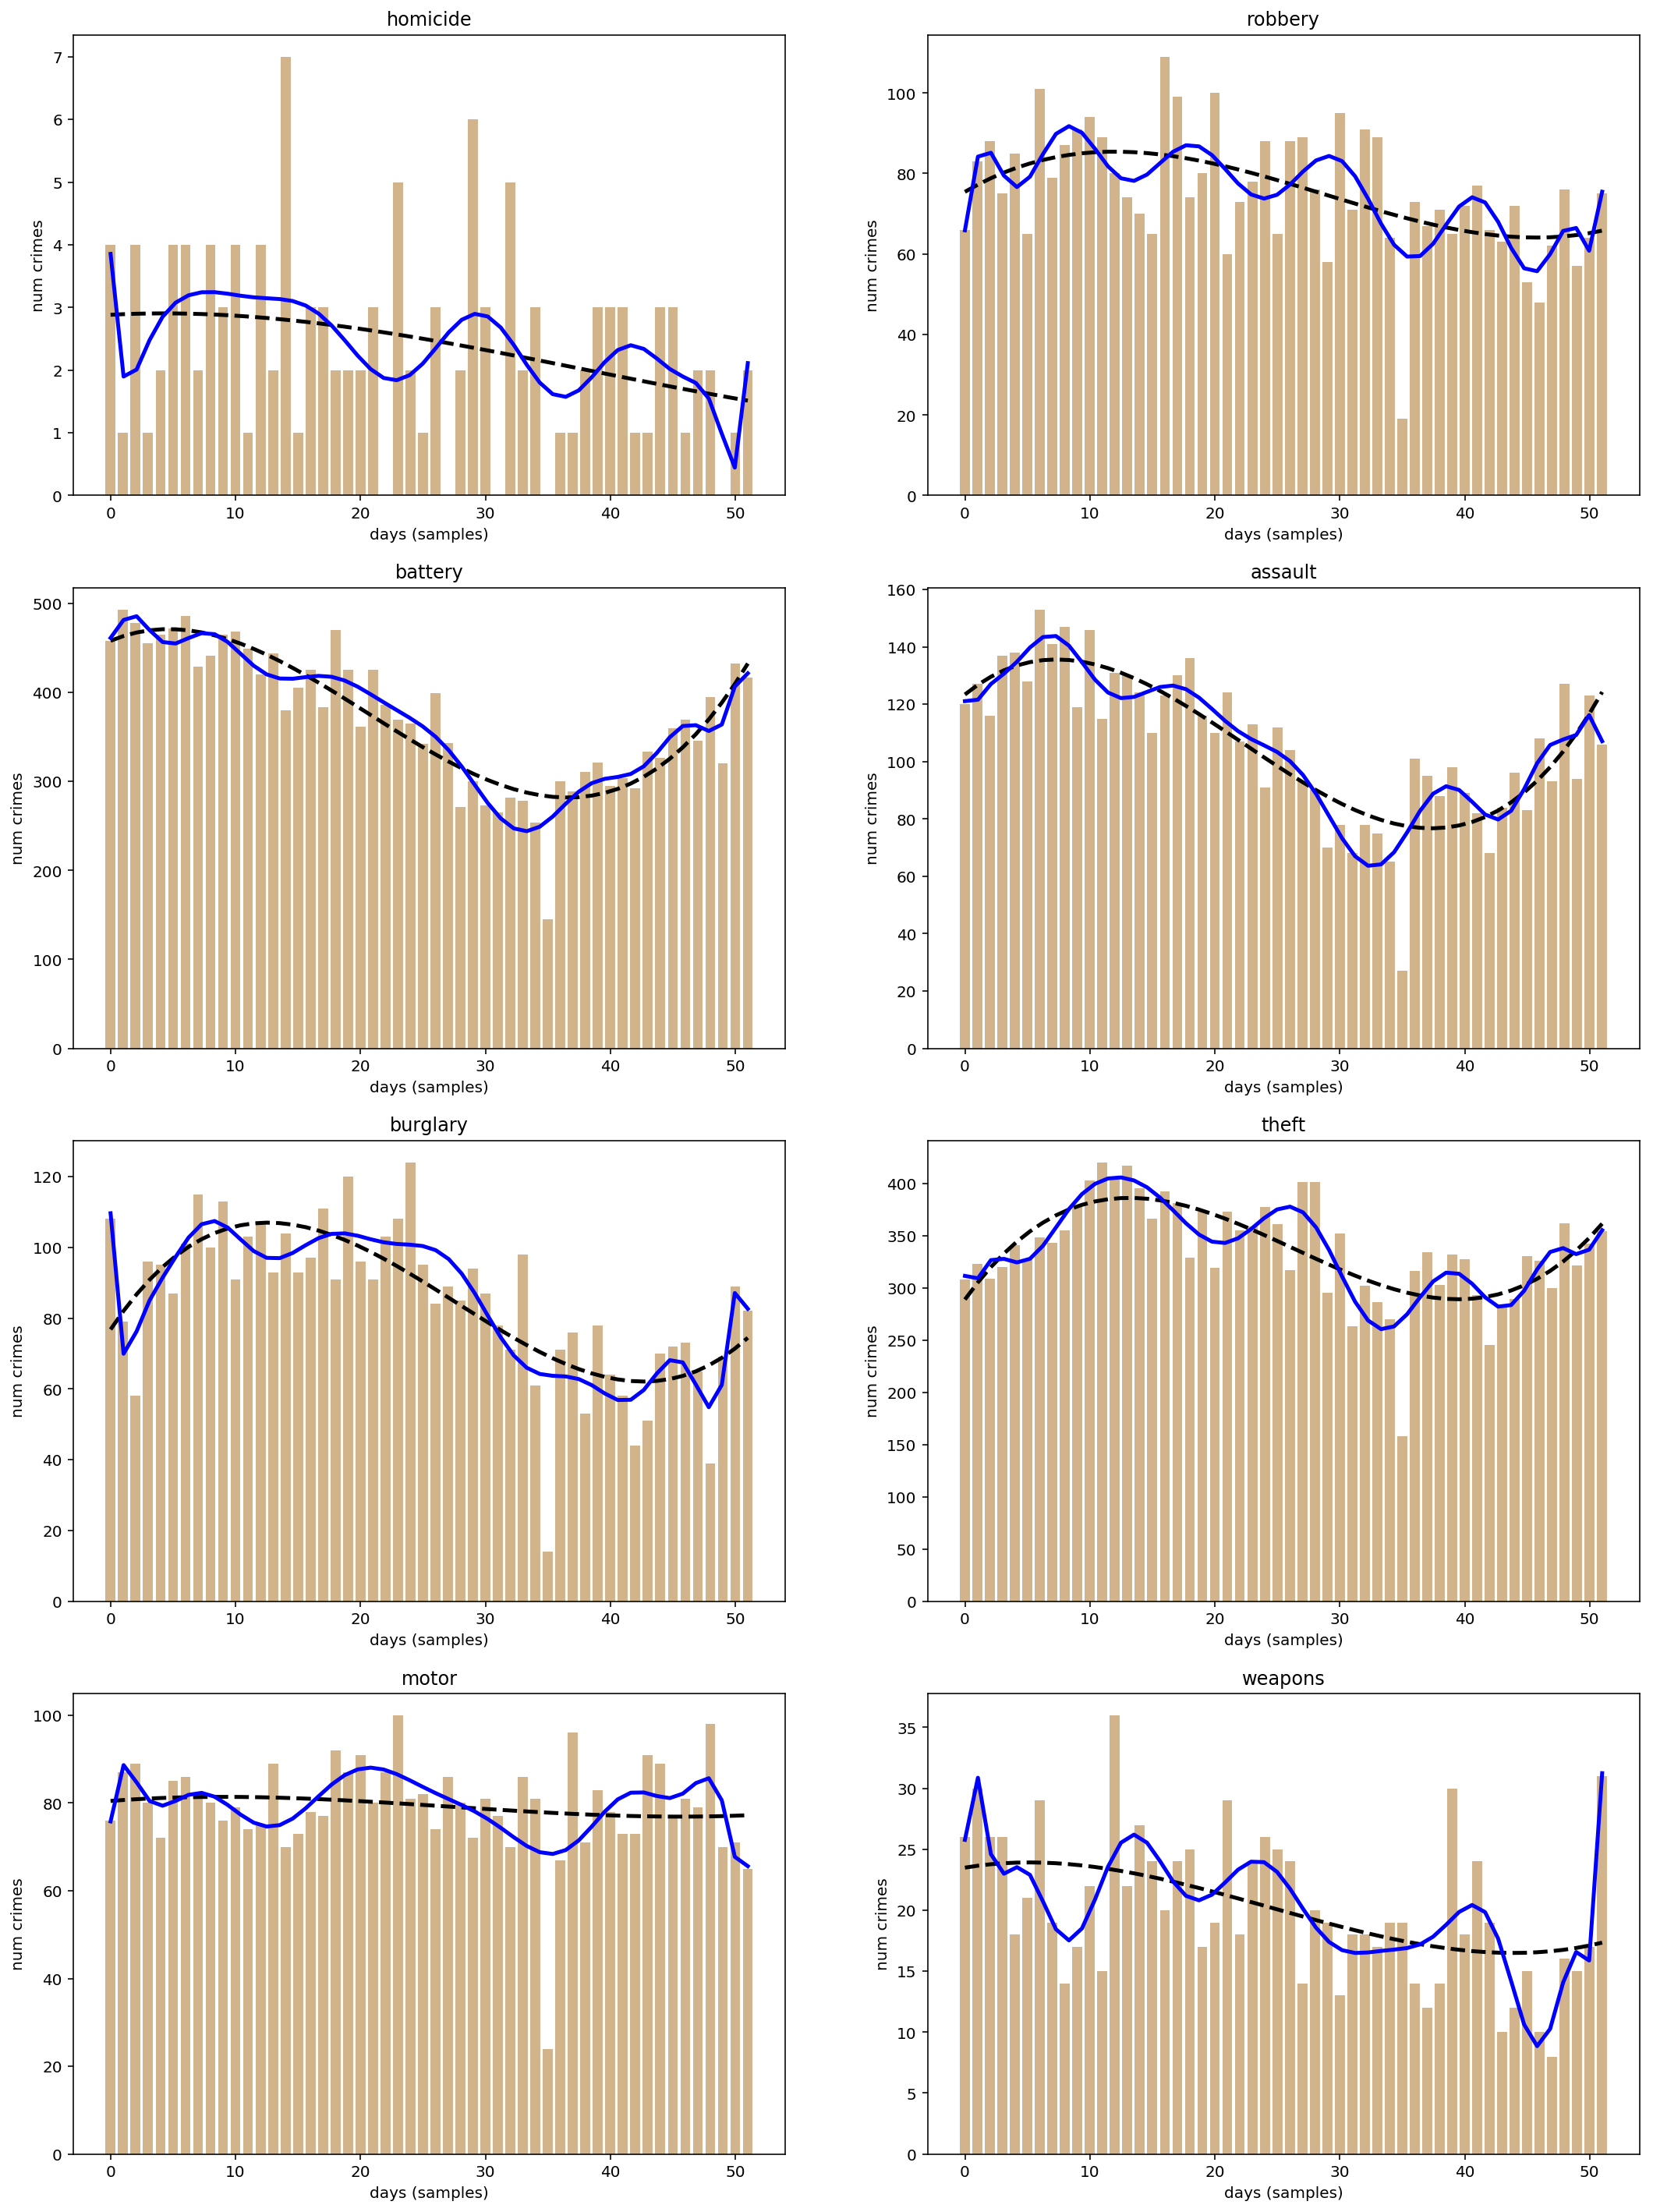

In [5]:
bar_test(year=4, district='5')

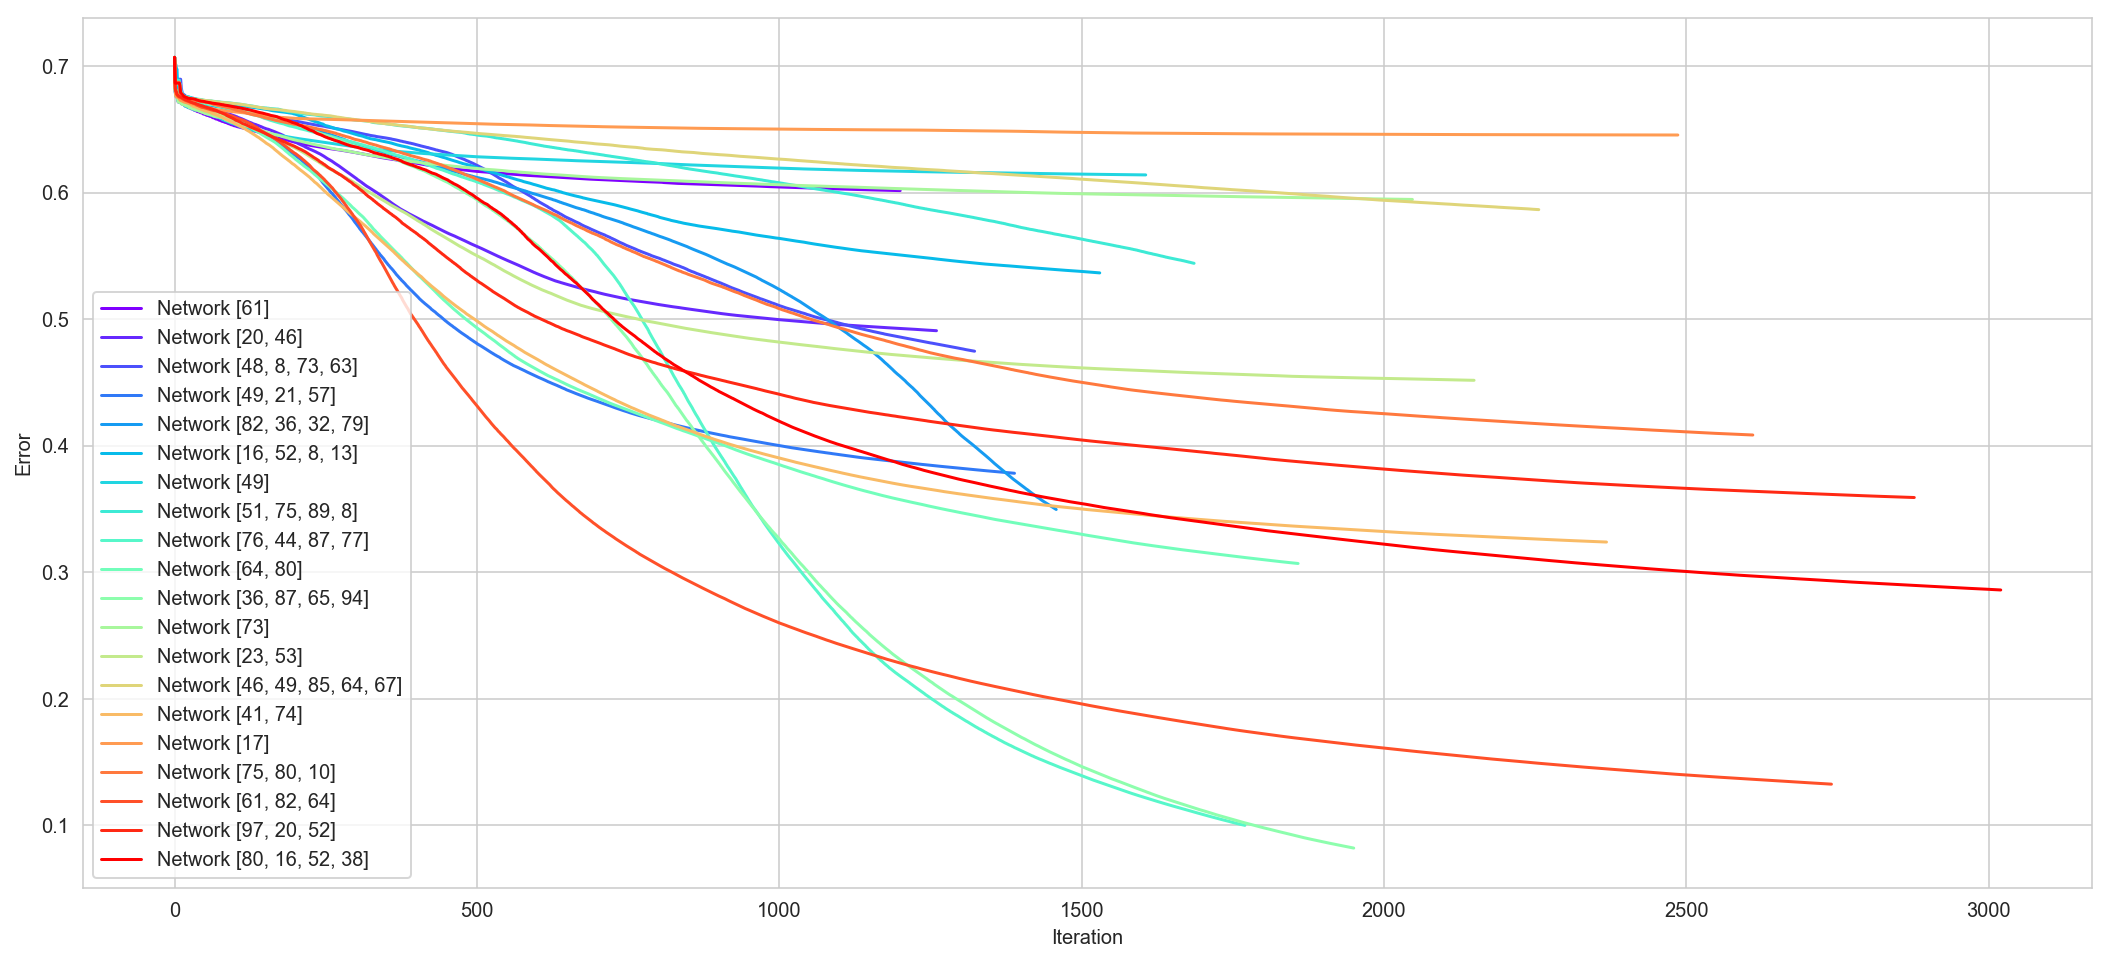

In [6]:
network_test(district='4')

# Results

## - BLAH
## - BLAH
## - BLAH

# Application

## - BLAH
## - BLAH
## - BLAH

In [189]:
save_dill(iterations=100, normalize=True, partition=False)

In [190]:
import dill
import numpy as np
import pandas as pd

fp = open('trained_models.pickle', 'rb')
trained_models = dill.load(fp)
fp.close()

In [191]:
dry_bulb_temp = 69.212739
wet_bulb_temp = 59.030585
wind_speed = 4.519358
relative_humidity = 72.286077

data = [dry_bulb_temp, wet_bulb_temp, wind_speed, relative_humidity]
trained_models.use(data, return_all=True, district=None)

| 1: Far North Side | 2:     North Side | 3:       N-W Side | 4:        Central | 5:      West Side 
| 6:       S-W Side | 7:     South Side | 8:   Far S-W Side | 9:  Far West Side |


,Homicide,Robbery,Battery,Assault,Burglary,Theft,Motor Theft,Weapons Assault
1,1,21,102,31,43,181,45,2
2,0,23,51,8,52,231,28,1
3,0,14,77,28,32,105,35,6
4,0,13,45,17,8,214,14,1
5,3,71,274,90,65,277,59,22
6,3,39,265,87,55,173,49,14
7,2,55,294,95,52,233,51,12
8,1,8,61,24,3,53,14,3
9,1,40,153,48,47,103,47,4


# Challenges

## - BLAH
## - BLAH
## - BLAH

# Conclusion

## - BLAH
## - BLAH
## - BLAH